Group members:
Amira Matoussi,
Zaineb Boujelbene,
Leila Skouri,
Hamza Jelassi,
Mohamed Yessine Laabidi,
Mehdi Kallel.

#  **Object Detection Using Adaptive Mask RCNN in Optical Remote Sensing Images**

### **Data Preparation:**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

**Loading and resizing data**

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive/')"""

Mounted at /content/drive/


In [ ]:
#!cp -r /content/drive/MyDrive/NWPUVHR-10dataset/. /content/DeepLab_NWPU-VHR-10_Dataset_coco/NWPU-VHR-10_dataset_coco

In [ ]:
!pip install rarfile

In [ ]:
import os
from rarfile import RarFile

# Define the path to the .rar file
rar_file_path = '/content/NWPU VHR-10 dataset.rar'

# Define the directory to extract the contents to
extract_dir = '/content/extracted/'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the .rar file
with RarFile(rar_file_path, 'r') as rar_ref:
    rar_ref.extractall(extract_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['NWPU VHR-10 dataset']


In [ ]:
import os
import cv2

# Define function to process each annotation line
def process_line(line):
    # Clean and split the line to extract numbers
    cleaned_text = line.strip().replace('(', '').replace(')', '')
    numbers = cleaned_text.split(',')

    # Check if we have enough values to unpack
    if len(numbers) != 5:
        return None

    # Extract numerical values and class label
    x1, y1, x2, y2, class_label = map(int, numbers)
    return x1, y1, x2, y2, class_label


def load_data(image_dir, annotation_dir):
    images = []
    annotations = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            annotation_path = os.path.join(annotation_dir, filename.replace(".jpg", ".txt"))

            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize image to 1024x1024
            resized_image = cv2.resize(image, (1024, 1024))
            images.append(resized_image)

            # Parse annotations
            with open(annotation_path, 'r') as file:
                boxes = []
                for line in file:
                    annotation = process_line(line)
                    if annotation is not None:
                        # Adjust annotations for resizing
                        x1, y1, x2, y2, class_label = annotation
                        x1_resized = int(x1 * 1024 / image.shape[1])
                        y1_resized = int(y1 * 1024 / image.shape[0])
                        x2_resized = int(x2 * 1024 / image.shape[1])
                        y2_resized = int(y2 * 1024 / image.shape[0])
                        boxes.append([x1_resized, y1_resized, x2_resized, y2_resized, class_label])
                annotations.append(boxes)

    return images, annotations

image_dir = '/content/DeepLab_NWPU-VHR-10_Dataset_coco/NWPU-VHR-10_dataset_coco/positive_image_set'
annotation_dir = '/content/DeepLab_NWPU-VHR-10_Dataset_coco/NWPU-VHR-10_dataset_coco/ground_truth'
images, annotations = load_data(image_dir, annotation_dir)

# Define class labels
class_labels = {
    1: "airplane",
    2: "ship",
    3: "storage tank",
    4: "baseball diamond",
    5: "tennis court",
    6: "basketball court",
    7: "ground track field",
    8: "harbor",
    9: "bridge",
    10: "vehicle"
}

**Splitting**

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_annotations, test_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)

In [ ]:
print("Number of loaded images:", len(images))
print("Number of loaded annotations:", len(annotations))

Number of loaded images: 650
Number of loaded annotations: 650


#### **Data Augmentation**

**Rotation:**

In [ ]:
def rotate_point(x, y, angle):
    # Rotate point (x, y) around the origin (0, 0) by given angle in degrees
    angle_rad = np.deg2rad(angle)
    rotated_x = int(np.cos(angle_rad) * x - np.sin(angle_rad) * y)
    rotated_y = int(np.sin(angle_rad) * x + np.cos(angle_rad) * y)
    return rotated_x, rotated_y

def rotate_annotations(annotations, angle, image_width, image_height):
    rotated_annotations = []
    center_x = image_width / 2
    center_y = image_height / 2
    for x1, y1, x2, y2, class_id in annotations:
        # Translate the coordinates to the origin
        x1 -= center_x
        y1 -= center_y
        x2 -= center_x
        y2 -= center_y

        # Rotate bounding box coordinates around the origin
        rotated_x1 = int(np.cos(np.radians(angle)) * x1 - np.sin(np.radians(angle)) * y1) + center_x
        rotated_y1 = int(np.sin(np.radians(angle)) * x1 + np.cos(np.radians(angle)) * y1) + center_y
        rotated_x2 = int(np.cos(np.radians(angle)) * x2 - np.sin(np.radians(angle)) * y2) + center_x
        rotated_y2 = int(np.sin(np.radians(angle)) * x2 + np.cos(np.radians(angle)) * y2) + center_y

        rotated_annotations.append([rotated_x1, rotated_y1, rotated_x2, rotated_y2, class_id])
    return rotated_annotations

**Flipping:**

In [ ]:
def flip_annotations(annotations, flip_code, image_width, image_height):
    flipped_annotations = []
    for x1, y1, x2, y2, class_id in annotations:
        # Flip bounding box coordinates
        if flip_code == 1:  # Horizontal flip
            flipped_x1 = image_width - x2
            flipped_x2 = image_width - x1
            flipped_y1, flipped_y2 = y1, y2
        elif flip_code == 0:  # Vertical flip
            flipped_y1 = image_height - y2
            flipped_y2 = image_height - y1
            flipped_x1, flipped_x2 = x1, x2
        elif flip_code == -1:  # Both horizontal and vertical flip
            flipped_x1 = image_width - x2
            flipped_x2 = image_width - x1
            flipped_y1 = image_height - y2
            flipped_y2 = image_height - y1
        flipped_annotations.append([flipped_x1, flipped_y1, flipped_x2, flipped_y2, class_id])
    return flipped_annotations

**Applying the Augmentation:**

In [ ]:
def augment_data(images, annotations):
    augmented_images = []
    augmented_annotations = []

    for image, image_annotations in zip(images, annotations):
        # Original image and annotations
        augmented_images.append(image)
        augmented_annotations.append(image_annotations)

        # Rotate the image by 180 degrees
        for angle in [180]:
            rotated_image = np.rot90(image, k=angle // 90)
            rotated_annotations = rotate_annotations(image_annotations, angle, image.shape[1], image.shape[0])
            augmented_images.append(rotated_image)
            augmented_annotations.append(rotated_annotations)

        # Flip the image horizontally and vertically
        for flip_code in [1, 0, -1]:
            flipped_image = cv2.flip(image, flip_code)
            flipped_annotations = flip_annotations(image_annotations, flip_code, image.shape[1], image.shape[0])
            augmented_images.append(flipped_image)
            augmented_annotations.append(flipped_annotations)

    return augmented_images, augmented_annotations

# Apply data augmentation to the training set
augmented_train_images, augmented_train_annotations = augment_data(train_images, train_annotations)

**Data After Augmentation:**

In [ ]:
print("Number of train images:", len(train_images))
print("Number of augmented train images:", len(augmented_train_images))
print("Number of train annotations:", len(train_annotations))
print("Number of augmented train annotations:", len(augmented_train_annotations))

Number of train images: 455
Number of augmented train images: 2275
Number of train annotations: 455
Number of augmented train annotations: 2275


**Visualizing augmented data:**

Annotations for Augmented Image 1: [[690, 129, 810, 330, 4], [188, 28, 517, 734, 7]]


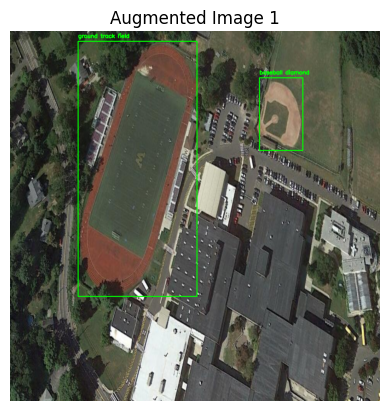

Annotations for Augmented Image 2: [[335.0, 895.0, 214.0, 694.0, 4], [836.0, 995.0, 507.0, 290.0, 7]]


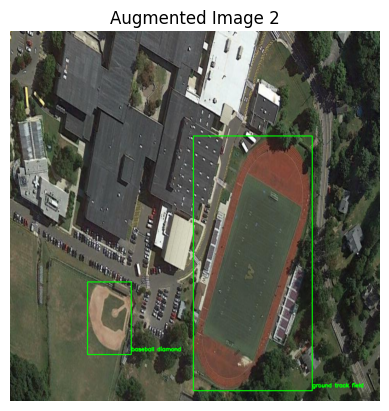

Annotations for Augmented Image 3: [[214, 129, 334, 330, 4], [507, 28, 836, 734, 7]]


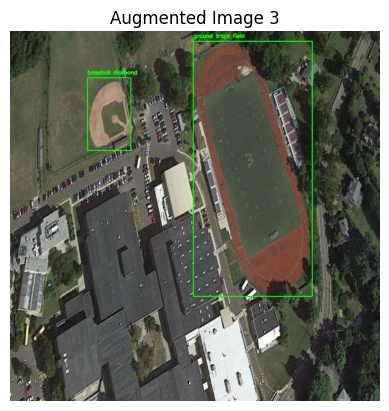

Annotations for Augmented Image 4: [[690, 694, 810, 895, 4], [188, 290, 517, 996, 7]]


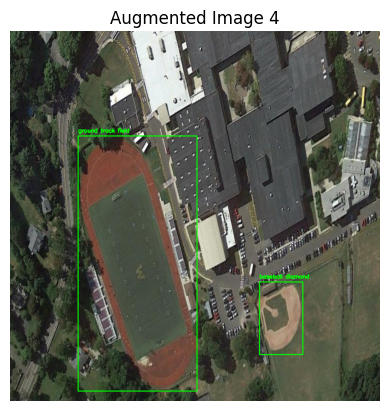

Annotations for Augmented Image 5: [[214, 694, 334, 895, 4], [507, 290, 836, 996, 7]]


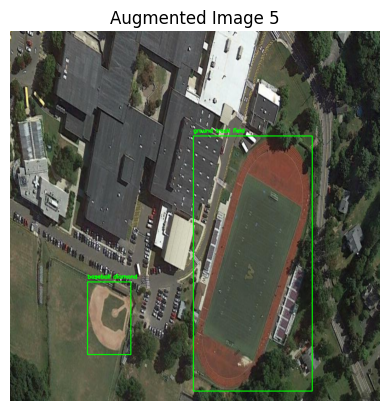

Annotations for Augmented Image 6: [[375, 114, 518, 229, 8], [363, 267, 541, 377, 8], [368, 359, 559, 474, 8], [375, 474, 582, 578, 8], [382, 576, 578, 706, 8], [418, 713, 607, 851, 8]]


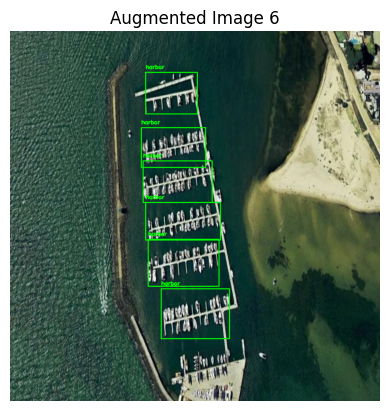

Annotations for Augmented Image 7: [[649.0, 910.0, 507.0, 795.0, 8], [661.0, 756.0, 484.0, 647.0, 8], [656.0, 664.0, 466.0, 550.0, 8], [649.0, 549.0, 442.0, 447.0, 8], [642.0, 448.0, 446.0, 318.0, 8], [605.0, 311.0, 417.0, 173.0, 8]]


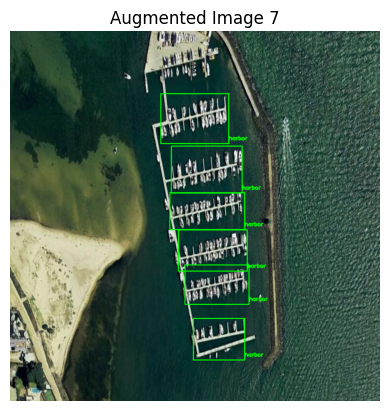

Annotations for Augmented Image 8: [[506, 114, 649, 229, 8], [483, 267, 661, 377, 8], [465, 359, 656, 474, 8], [442, 474, 649, 578, 8], [446, 576, 642, 706, 8], [417, 713, 606, 851, 8]]


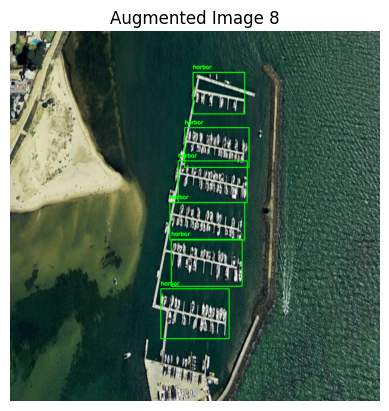

Annotations for Augmented Image 9: [[375, 795, 518, 910, 8], [363, 647, 541, 757, 8], [368, 550, 559, 665, 8], [375, 446, 582, 550, 8], [382, 318, 578, 448, 8], [418, 173, 607, 311, 8]]


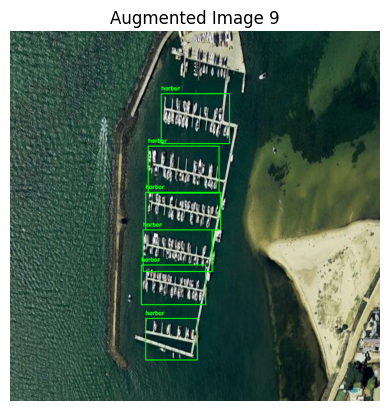

Annotations for Augmented Image 10: [[506, 795, 649, 910, 8], [483, 647, 661, 757, 8], [465, 550, 656, 665, 8], [442, 446, 649, 550, 8], [446, 318, 642, 448, 8], [417, 173, 606, 311, 8]]


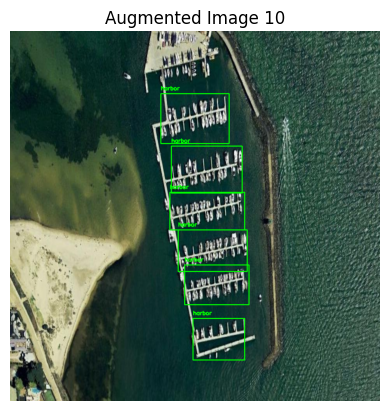

Annotations for Augmented Image 11: [[285, 205, 360, 308, 1], [327, 320, 400, 423, 1], [352, 471, 423, 569, 1], [354, 629, 436, 738, 1], [364, 775, 444, 884, 1], [643, 240, 720, 361, 1], [649, 391, 726, 511, 1]]


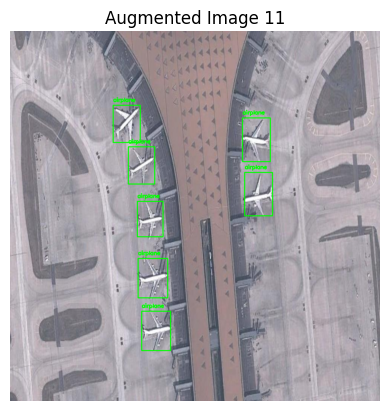

Annotations for Augmented Image 12: [[739.0, 819.0, 664.0, 715.0, 1], [697.0, 703.0, 624.0, 600.0, 1], [672.0, 552.0, 601.0, 455.0, 1], [669.0, 395.0, 587.0, 286.0, 1], [659.0, 249.0, 579.0, 140.0, 1], [382.0, 784.0, 305.0, 663.0, 1], [376.0, 633.0, 298.0, 513.0, 1]]


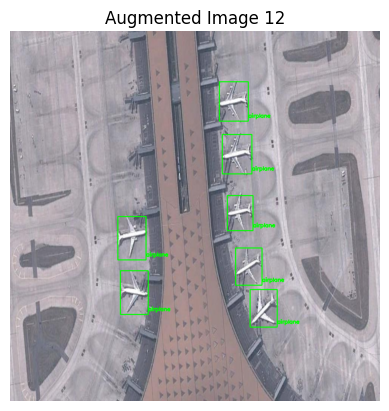

In [ ]:
import matplotlib.pyplot as plt

def draw_boxes(image, annotations):
    for annotation in annotations:
        x1, y1, x2, y2, class_id = annotation
        class_name = class_labels[class_id]
        # Convert coordinates to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Visualize augmented images with bounding boxes and class names
for i in range(12):
    image = augmented_train_images[i]
    annotations = augmented_train_annotations[i]
    print(f"Annotations for Augmented Image {i+1}: {annotations}")
    image_with_boxes = draw_boxes(image.copy(), annotations)
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.title(f"Augmented Image {i+1}")
    plt.show()

### **Modeling:**

**Mask_RCNN:**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy

def Mask_RCNN(input_shape, fine_tune_strategy):
    # Backbone (ResNet50)
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze layers based on fine-tuning strategy
    if fine_tune_strategy == 1:
        # Freeze all layers except the head layer
        for layer in backbone.layers[:-5]:
            layer.trainable = False
    elif fine_tune_strategy == 2:
        # Freeze layers up to convolution layer (+4)
        for layer in backbone.layers[:-17]:
            layer.trainable = False
    elif fine_tune_strategy == 3:
        # Freeze layers up to convolution layer (+3)
        for layer in backbone.layers[:-34]:
            layer.trainable = False

    # Feature Pyramid Network (FPN)
    pyramid_layers = [backbone.get_layer(name).output for name in ["conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]]

    # Region Proposal Network (RPN)
    rpn_input = backbone.output
    rpn_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(rpn_input) # Example layer
    # Define more RPN layers...
    rpn_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(rpn_output)
    rpn_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(rpn_output)

    # Fully Convolutional Network (FCN) for Mask
    fcn_input = backbone.output
    mask_output = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(fcn_input) # Example layer
    # Define more FCN layers...
    mask_output = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(mask_output)
    mask_output = Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(mask_output)

    # Define final model
    model = Model(inputs=backbone.input, outputs=[rpn_output, mask_output])

    return model

**Loss function:**

In [ ]:
def mask_rcnn_loss(y_true, y_pred):
    classification_loss = binary_crossentropy(y_true[0], y_pred[0])
    bounding_box_loss = binary_crossentropy(y_true[1], y_pred[1])  # Example bounding box loss

    # Mask loss according to Eq. (2)
    mask_true, mask_pred = y_true[2], y_pred[2]
    mask_loss = -tf.reduce_mean(
        tf.reduce_sum(
            mask_true * tf.math.log(mask_pred) +
            (1 - mask_true) * tf.math.log(1 - mask_pred),
            axis=[1, 2]
        )
    )

    total_loss = classification_loss + bounding_box_loss + mask_loss
    return total_loss

**Training the model:**

In [ ]:
def train_model(model, images, annotations, epochs=10, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=mask_rcnn_loss)

    # Prepare input data as a list of dictionaries
    input_data = []
    output_data = []
    for image, annotation in zip(images, annotations):
        boxes_array = np.array([np.array(box) for box in annotation['boxes']])
        input_data.append({
            'input_image': np.array(image),
            'input_boxes': boxes_array,
            'input_classes': np.array(annotation['classes']),
            'input_masks': np.array(annotation['masks'])
        })
        output_data.append({
            'output_boxes': boxes_array,
            'output_classes': np.array(annotation['classes']),
            'output_masks': np.array(annotation['masks'])
        })

    # Train the model
    model.fit(input_data, output_data, epochs=epochs, batch_size=batch_size)

In [ ]:
# Define the fixed size of the resized images
image_height = 1024
image_width = 1024

# Prepare augmented data for model training
formatted_annotations = []
for annotation in augmented_train_annotations:
    formatted_boxes = []
    formatted_masks = []
    for box in annotation:
        x1, y1, x2, y2, class_label = box
        formatted_boxes.append([x1, y1, x2, y2])
        # Create mask
        mask = np.zeros((image_height, image_width))
        mask[int(y1 * image_height):int(y2 * image_height), int(x1 * image_width):int(x2 * image_width)] = 1
        formatted_masks.append(mask)
    formatted_annotations.append({'boxes': formatted_boxes, 'classes': [class_label], 'masks': formatted_masks})

# Extract images, boxes, classes, and masks from formatted annotations
images = augmented_train_images
boxes = [annotation['boxes'] for annotation in formatted_annotations]
classes = [annotation['classes'] for annotation in formatted_annotations]
masks = [annotation['masks'] for annotation in formatted_annotations]

In [ ]:
# Fine-tuning strategy
fine_tune_strategy = 1

# Train the model
input_shape = (image_height, image_width, 3)
model = Mask_RCNN(input_shape, fine_tune_strategy)
train_model(model, images, formatted_annotations, epochs=30, batch_size=32, learning_rate=0.1)

### **Evaluation:**

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)

**Intersection over Union (IoU):**

In [ ]:
def calculate_iou(box1, box2):
    # Implement the Intersection over Union (IoU) calculation
    x1_int = max(box1[0], box2[0])
    y1_int = max(box1[1], box2[1])
    x2_int = min(box1[2], box2[2])
    y2_int = min(box1[3], box2[3])

    intersection_area = max(0, x2_int - x1_int + 1) * max(0, y2_int - y1_int + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

**Average Precision (AP):**

In [ ]:
def compute_ap(y_true, y_pred):
    ap_scores = []
    for true_boxes, pred_boxes in zip(y_true, y_pred):
        ap_scores_per_class = []
        for true_box in true_boxes:
            iou_scores = [calculate_iou(true_box, pred_box) for pred_box in pred_boxes]
            best_iou = max(iou_scores)
            ap_scores_per_class.append(best_iou)
        ap_scores.append(np.mean(ap_scores_per_class))
    return np.mean(ap_scores)

iou = compute_ap(test_annotations, predictions[0])
print("Mean IoU:", iou)

**The Precision-Recall curve:**

In [ ]:
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

**Average Precision-Recall score**

In [ ]:
from sklearn.metrics import average_precision_score

# You need to obtain confidence scores from your model predictions
y_scores = []
plot_precision_recall_curve(test_annotations, y_scores)

# Compute average precision
average_precision = average_precision_score(test_annotations, y_scores)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

**Computation time**

In [ ]:
# Compute computation time
import time

start_time = time.time()
predictions = model.predict(test_images)
end_time = time.time()
total_time = end_time - start_time
print("Total Inference Time:", total_time)

**Loss and Accuracy**

In [ ]:
# Evaluate performances using loss and accuracy in addition to precision and recall
loss, accuracy = model.evaluate(test_images, test_annotations)
print("Loss:", loss)
print("Accuracy:", accuracy)